# Driver script for the synthetic data

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
import torch.nn as nn
import torch.functional as F
import torch.distributions as dist
from collections import defaultdict


transform_to_tensor = ToTensor()

c:\Users\bends\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import NFiVAE_synth as class_nfivae
import iVAE_synth as class_ivae
import VAE_synth as class_vae

## Generate Synthetic data

In [3]:
# Functions to generate synthetic dataset
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=3, out_features=hidden_size),
            nn.Linear(in_features=hidden_size, out_features=10),
        )

    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples):
    envs = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    Z3 = Y + env + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2, Z3], axis = 1)

    synthnn = SynthNN()
    X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        E = torch.tensor(E)
        self.E = torch.nn.functional.one_hot(E.long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))

In [4]:
#Generate data
torch.manual_seed(1)
X, Y, envs, Z, E = simulate_synthetic_data(8000)
dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset1 = EnvDataset(X[4000:],Y[4000:],envs[4000:])
test_loader = DataLoader(dset1, batch_size=128, drop_last=True)

# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]
environment = sample[2]

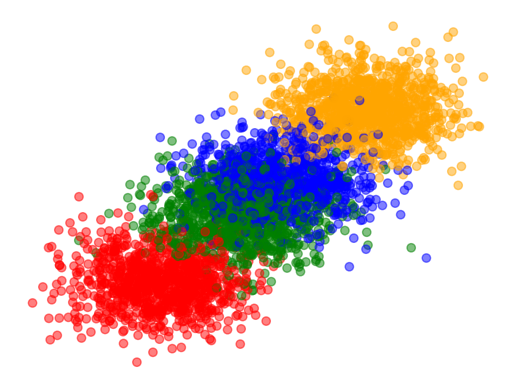

In [5]:
#Visualizing latent variable used to generate the data
z_full = Z[4000:,:]
enviro = envs[4000:]

z_df = pd.DataFrame(z_full)
e_df = pd.DataFrame(enviro)

df = z_df;
df.columns = ['Z1', 'Z2','Z3']
df['E'] = e_df[0]

colors = []
for col in df["E"]:
    if col == (0):
        colors.append("red")
    elif col == (1):
        colors.append("green")
    elif col == (2):
        colors.append("blue")
    elif col == (3):
        colors.append("orange")

df["colour"] = colors
plt.scatter(df["Z1"], df["Z2"], c=df["colour"]).set_alpha(0.5)
plt.axis("off"); plt.show()

## NF-iVAE

In [6]:
#Load NF-iVAE
latent_features = 3
nf_ivae = class_nfivae.NFiVAE_synth(images[0].shape, latent_features)
print(nf_ivae)

NFiVAE_synth(
  (Lambdafnl_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
  )
  (TNN_prior): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=3, bias=True)
  )
  (LambdaNN_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
  (NonLinearEncoder): Sequential(
    (0): Linear(in_features=15, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
  )
  (NonLinearDecoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
  (relu): ReLU()
)


In [7]:
#Train NF-iVAE
# define the models, evaluator and optimizer
device = torch.device("cpu")
print(f">> Using device: {device}")

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(nf_ivae.parameters(), lr=1e-3) #Hyper parameter

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

torch.manual_seed(1)
num_epochs = 1000 #Hyper parameter

# move the model to the device
# nf_ivae = nf_ivae.to(device)
sample_counter = 0
# training..
for i in tqdm(range(num_epochs)):

    training_epoch_data = defaultdict(list)
    nf_ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)

        y = sample[1]
        y = y.to(device)

        e = sample[2]
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO and SM loss
        optimizer.zero_grad()
        loss, diagnostics, outputs = nf_ivae.VariationalInference(x.float(), y.float(), e.float())
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

>> Using device: cpu


100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


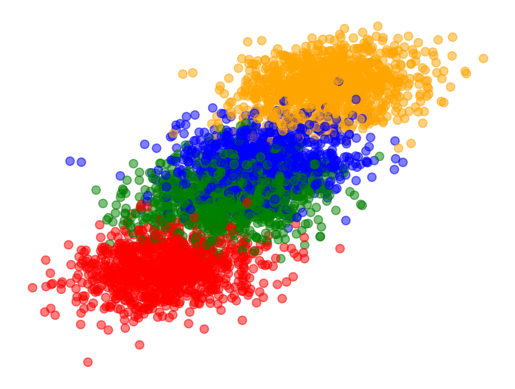

In [8]:
#Plotting NF-iVAE results
nf_ivae.eval()

loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x1 = sample[0]
y1 = sample[1]
e1 = sample[2]

output = nf_ivae.forward(x1.float(), y1.float(), e1.float())

z1 = output['z']
z_full1 = z1
e_full1 = e1

enviro1 = np.zeros((len(e_full1),1))
for i in range(0,4):
    inde = e_full1[:,i] == 1
    enviro1[inde] = i+1

z_df1 = pd.DataFrame(z_full1.detach())
e_df1 = pd.DataFrame(enviro1)

df1 = z_df1
df1.columns = ['Z1', 'Z2','Z3']

df1['E'] = e_df1
colors = []

for col in df1["E"]:
    if col == (1.0):
        colors.append("red")
    elif col == (2.0):
        colors.append("green")
    elif col == (3.0):
        colors.append("blue")
    elif col == (4.0):
        colors.append("orange")

df1["colour"] = colors

colors = np.array(["r", "g", "b", "y"])

plt.scatter(df1["Z1"], df1["Z2"], c=df1["colour"]).set_alpha(0.5); 
plt.axis("off"); plt.show()

## iVAE

In [9]:
#Load iVAE
latent_features = 3
ivae = class_ivae.iVAE_synth(images[0].shape, latent_features)
print(ivae)

iVAE_synth(
  (Lambdaf_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (NonLinearEncoder): Sequential(
    (0): Linear(in_features=15, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
  )
  (NonLinearDecoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
)


In [10]:
#Train iVAE
# define the models, evaluator and optimizer
device = torch.device("cpu")
print(f">> Using device: {device}")

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-3) #Hyper parameter

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

torch.manual_seed(1)
num_epochs = 1000 #Hyper parameter

# move the model to the device
# nf_ivae = nf_ivae.to(device)
sample_counter = 0
# training..
for i in tqdm(range(num_epochs)):
    # epoch+= 1
    training_epoch_data = defaultdict(list)
    ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)

        y = sample[1]
        y = y.to(device)

        e = sample[2]
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = ivae.VariationalInference(x.float(), y.float(), e.float(), beta = 1)
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

>> Using device: cpu


100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s]


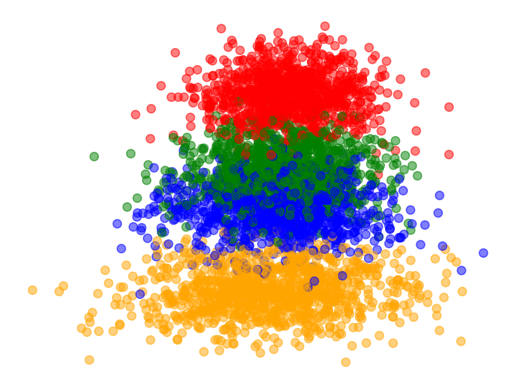

In [11]:
#Plotting iVAE results
ivae.eval()

loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x2 = sample[0]
y2 = sample[1]
e2 = sample[2]

output = ivae.forward(x2.float(), y2.float(), e2.float())

z2 = output['z']
z_full2 = z2
e_full2 = e2

enviro2 = np.zeros((len(e_full2),1))
for i in range(0,4):
    inde = e_full2[:,i] == 1
    enviro2[inde] = i+1

z_df2 = pd.DataFrame(z_full2.detach())
e_df2 = pd.DataFrame(enviro2)

df2 = z_df2
df2.columns = ['Z1','Z2','Z3']

df2['E'] = e_df2
colors = []

for col in df2["E"]:
    if col == (1.0):
        colors.append("red")
    elif col == (2.0):
        colors.append("green")
    elif col == (3.0):
        colors.append("blue")
    elif col == (4.0):
        colors.append("orange")

df2["colour"] = colors

colors = np.array(["r", "g", "b", "y"])

plt.scatter(df2["Z1"], df2["Z2"], c=df2["colour"]).set_alpha(0.5); 
plt.axis("off"); plt.show()

## VAE

In [12]:
#Load VAE
latent_features = 3
vae = class_vae.VAE_synth(images[0].shape, latent_features)
print(vae)

VAE_synth(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
)


In [13]:
#Train VAE
# define the models, evaluator and optimizer
device = torch.device("cpu")
print(f">> Using device: {device}")

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) #Hyper parameter

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

torch.manual_seed(1)
num_epochs = 1000 #Hyper parameter

# move the model to the device
# vae = vae.to(device)
sample_counter = 0
# training..
for i in tqdm(range(num_epochs)):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    for sample in train_loader:
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = vae.VariationalInference(x.float(), beta = 1)
        loss.backward()
        optimizer.step()
        
        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

>> Using device: cpu


100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


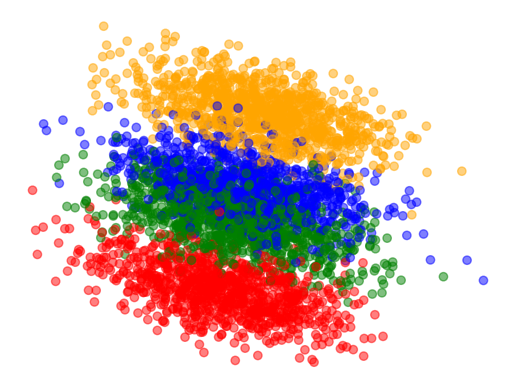

In [18]:
#Plotting VAE results
vae.eval()

loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x3 = sample[0]
e3 = sample[2]

output = vae.forward(x3.float())

z3 = output['z']
z_full3 = z3
e_full3 = e3

enviro3 = np.zeros((len(e_full3),1))
for i in range(0,4):
    inde = e_full3[:,i] == 1
    enviro3[inde] = i+1

z_df3 = pd.DataFrame(z_full3.detach())
e_df3 = pd.DataFrame(enviro3)

df3 = z_df3
df3.columns = ['Z1','Z2','Z3']

df3['E'] = e_df3
colors = []

for col in df3["E"]:
    if col == (1.0):
        colors.append("red")
    elif col == (2.0):
        colors.append("green")
    elif col == (3.0):
        colors.append("blue")
    elif col == (4.0):
        colors.append("orange")

df3["colour"] = colors

colors = np.array(["r", "g", "b", "y"])

plt.scatter(df3["Z1"], df3["Z2"], c=df3["colour"]).set_alpha(0.5); 
plt.axis("off"); plt.show()
